# Import Libraries

In [1]:
import gym
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam

import numpy as np
import matplotlib.pyplot as plt
import random
from collections import deque
import os

# Baseline DQN Model

In [2]:
class DQN:
  def __init__(self,
               InputShape,
               NActions,
               Gamma,
               ReplayMemorySize,
               MinReplayMemory,
               UpdateTargetEveryThisEpisodes,
               IntermediateSize,
               BatchSize):
    '''Initialize the DQN agent with hyperparameters and networks'''
    # Hyperparameters
    self.InputShape = InputShape
    self.NActions = NActions
    self.Gamma = Gamma
    self.ReplayMemorySize = ReplayMemorySize
    self.MinReplayMemory = MinReplayMemory
    self.UpdateTargetEveryThisEpisodes = UpdateTargetEveryThisEpisodes
    self.IntermediateSize = IntermediateSize
    self.BatchSize = BatchSize

    # Create main and target neural networks
    self.Main = self.CreateModel('Main')
    self.Optimiser = Adam()
    self.Target = self.CreateModel('Target')
    self.Target.set_weights(self.Main.get_weights())  # Sync weights initially

    # Experience replay memory (deque with max length)
    self.ReplayMemory = deque(maxlen=ReplayMemorySize)

    # Counter to track when to update target network
    self.TargetUpdateCounter = 0

    # Track training losses: per batch and per episode averages
    self.loss_history = []  # flat list of batch losses
    self.episode_loss_averages = []  # average loss per episode

  def CreateModel(self, Type):
    '''Build the neural network model'''
    inputs = Input(shape=(self.InputShape,), name='Input')
    x = Dense(self.IntermediateSize, activation='relu', name='1stHiddenLayer')(inputs)
    x = Dense(self.IntermediateSize, activation='relu', name='2ndHiddenLayer')(x)
    outputs = Dense(self.NActions, activation='linear', name='Output')(x)

    NN = Model(inputs, outputs, name=Type)
    NN.summary()
    return NN

  def UpdateReplayMemory(self, Information):
    # Store new experience tuple (S, A, R, SNext, Done) in replay memory
    self.ReplayMemory.append(Information)

  def Train(self, EndOfEpisode):
    # Only train if replay memory has enough samples
    if len(self.ReplayMemory) < self.MinReplayMemory:
      print(f'DID NOT TRAIN..., replay memory = {len(self.ReplayMemory)}')
      return

    # Sample random batch from replay memory
    TrainingData = random.sample(self.ReplayMemory, self.BatchSize)

    # Extract states and get Q values from main network
    ListOfS = np.array([element[0] for element in TrainingData])
    ListOfQ = np.array(self.Main(ListOfS))

    # Extract next states and get Q values from target network
    ListOfSNext = np.array([element[3] for element in TrainingData])
    ListOfQNext = self.Target(ListOfSNext)

    # Prepare training data
    X = []
    Y = []
    for index, (S, A, R, SNext, Done) in enumerate(TrainingData):
      if not Done:
        MaxQNext = np.max(ListOfQNext[index])
        QNext = R + self.Gamma * MaxQNext
      else:
        QNext = R
      Q = ListOfQ[index]
      Q[A] = QNext  # Update Q value for the taken action

      X.append(S)
      Y.append(Q)

    # Perform one gradient step and record loss
    loss_tensor = self.GTfit(X, Y)
    self.loss_history.append(float(loss_tensor))

    # Update target network counter at end of episode
    if EndOfEpisode:
      self.TargetUpdateCounter += 1

    # Update target network weights periodically
    if self.TargetUpdateCounter >= self.UpdateTargetEveryThisEpisodes:
      self.Target.set_weights(self.Main.get_weights())
      self.TargetUpdateCounter = 0

  @tf.function
  def GTfit(self, X, Y):
    '''Training step using TensorFlow's GradientTape for automatic differentiation'''
    X_tensor = tf.convert_to_tensor(X)
    Y_tensor = tf.convert_to_tensor(Y)

    with tf.GradientTape() as tape:
      Predictions = self.Main(X_tensor, training=True)
      loss = tf.reduce_mean(tf.square(Y_tensor - Predictions))

    Grad = tape.gradient(loss, self.Main.trainable_variables)
    self.Optimiser.apply_gradients(zip(Grad, self.Main.trainable_variables))
    return loss


## Environment Setup and Agent Initialization

- We use the `Pendulum-v0` environment from OpenAI Gym.
- The continuous action space (torque between -2 and 2) is discretized into 21 equally spaced bins for compatibility with DQN.
- Key epsilon-greedy parameters are set for balancing exploration and exploitation.
- The DQN agent is instantiated with chosen hyperparameters, including replay memory size, discount factor, batch size, and network architecture.


In [3]:
# Create Pendulum environment
env = gym.make('Pendulum-v0')

# State space size (number of observations)
statesize = env.observation_space.shape[0]

# Discretize continuous action space into 21 bins between -2 and 2 (torque values)
numaction = 21
action_bins = np.linspace(-2, 2, numaction)
print(action_bins)

# Exploration parameters for epsilon-greedy policy
EpsilonMin = 0.01      # Minimum epsilon
EpsilonDecay = 0.995   # Decay rate per episode
Epsilon = 0.1          # Starting epsilon

ShowEvery = 10         # Frequency to update target network and show results

# Initialize the DQN agent with hyperparameters
base_agent = DQN(
  InputShape=statesize,
  NActions=numaction,
  Gamma=0.99,
  ReplayMemorySize=100000,
  MinReplayMemory=320,
  UpdateTargetEveryThisEpisodes=ShowEvery,
  IntermediateSize=64,
  BatchSize=64
)

[-2.  -1.8 -1.6 -1.4 -1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.   0.2  0.4  0.6
  0.8  1.   1.2  1.4  1.6  1.8  2. ]
Model: "Main"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 3)]               0         
                                                                 
 1stHiddenLayer (Dense)      (None, 64)                256       
                                                                 
 2ndHiddenLayer (Dense)      (None, 64)                4160      
                                                                 
 Output (Dense)              (None, 21)                1365      
                                                                 
Total params: 5,781
Trainable params: 5,781
Non-trainable params: 0
_________________________________________________________________
Model: "Target"
_________________________________________________________________
 L

## Action Conversion and Episode Execution

- **PendulumActionConverter:** Converts discrete action indices into continuous torque values within the environment's valid range.
- **PendulumInverseActionConverter:** Converts continuous torque values back to discrete indices, useful for evaluation or analysis.
- **OneEpisode:** Runs one full episode in the Pendulum environment using the DQN agent with ε-greedy policy:
  1. Obtain Q-values for current state.
  2. Select action via ε-greedy strategy.
  3. Execute action in the environment and observe outcomes.
  4. Store experience and train agent incrementally.
  5. After episode ends, perform a final training step and return total reward.


In [4]:
def PendulumActionConverter(A, NActions=numaction):
  # Convert discrete action index to continuous torque value
  ActualTorque = (A / NActions - 0.5) * 4
  return ActualTorque

def PendulumInverseActionConverter(A, NActions=numaction):
  # Convert continuous torque back to discrete action index
  ActualA = round((A + 2) * (NActions - 1) / 4)
  return ActualA

def OneEpisode(agent, env, action_bins):
  """
  Run one full episode using the given agent and environment.
  Returns the total accumulated reward.
  """
  S = env.reset()
  Done = False
  total_reward = 0

  while not Done:
    # 1) Get Q-values for current state from agent's main network
    q_vals = agent.Main(S.reshape(1, -1), training=False).numpy()[0]

    # 2) ε-greedy action selection
    if np.random.rand() < Epsilon:
      A = np.random.randint(0, agent.NActions)  # Explore: random action
    else:
      A = np.argmax(q_vals)  # Exploit: best predicted action

    # 3) Take action and observe next state, reward, and done flag
    SNext, R, Done, _ = env.step([action_bins[A]])
    total_reward += R

    env.render()

    # 4) Store experience and train agent (not end of episode yet)
    agent.UpdateReplayMemory((S, A, R, SNext, Done))
    agent.Train(EndOfEpisode=False)

    S = SNext

  # 5) Train once more at the end of the episode with EndOfEpisode=True
  agent.Train(EndOfEpisode=True)

  return total_reward


## Training Loop for the DQN Agent

- The agent trains over a maximum number of episodes specified by `episodes`.
- Epsilon (`ε`) follows an exponential decay to balance exploration and exploitation.
- After each episode:
  - The total reward and average loss are recorded.
  - The average reward over the most recent 20 episodes is computed.
  - If this recent average reward surpasses the early stopping threshold, training stops early.
- Each episode's duration, reward, average rewards, loss, and current epsilon are printed.
- The total training time is displayed at the end.


In [5]:
import time

def train_agent(base_agent, env, action_bins, episodes=500, early_stopping_threshold=-200,
                Epsilon=Epsilon, EpsilonDecay=EpsilonDecay, EpsilonMin=EpsilonMin):

  STARTTIME = time.time()

  reward_history = []
  epsilon_history = []

  for ep in range(episodes):
    ep_start = time.time()

    # Track where this episode's losses begin
    start_idx = len(base_agent.loss_history)

    # Run one episode
    total_reward = OneEpisode(base_agent, env, action_bins)
    reward_history.append(total_reward)

    # Decay epsilon
    Epsilon = max(EpsilonMin, Epsilon * EpsilonDecay)
    epsilon_history.append(Epsilon)

    # Calculate average loss for this episode
    ep_losses = base_agent.loss_history[start_idx:]
    ep_loss = sum(ep_losses) / len(ep_losses) if ep_losses else 0.0

    # Calculate reward statistics
    avg_reward = sum(reward_history) / len(reward_history)
    last20_avg_reward = sum(reward_history[-20:]) / len(reward_history[-20:])

    # Early stopping if recent performance exceeds threshold
    if last20_avg_reward > early_stopping_threshold:
      print(f"✅ Early stopping at episode {ep+1} with last20_avg_reward = {last20_avg_reward:.2f}")
      break

    # Duration of this episode
    ep_time = time.time() - ep_start

    print(
      f"Episode {ep+1:3d} | "
      f"Time: {ep_time:5.2f}s | "
      f"Reward: {total_reward:7.2f} | "
      f"AvgReward: {avg_reward:7.2f} | "
      f"Last20AvgReward: {last20_avg_reward:7.2f} | "
      f"Loss: {ep_loss:.4f} | "
      f"ε: {Epsilon:.4f}"
    )

  print(f"\nTotal time taken: {time.time() - STARTTIME:.2f}s")

  return reward_history, epsilon_history


In [6]:
# Start Training DQN Agent
reward_history, epsilon_history = train_agent(
  base_agent,
  env,
  action_bins,
  episodes=500,
  early_stopping_threshold=-200,
  Epsilon=Epsilon,
  EpsilonDecay=EpsilonDecay,
  EpsilonMin=EpsilonMin
)


DID NOT TRAIN..., replay memory = 1
DID NOT TRAIN..., replay memory = 2
DID NOT TRAIN..., replay memory = 3
DID NOT TRAIN..., replay memory = 4
DID NOT TRAIN..., replay memory = 5
DID NOT TRAIN..., replay memory = 6
DID NOT TRAIN..., replay memory = 7
DID NOT TRAIN..., replay memory = 8
DID NOT TRAIN..., replay memory = 9
DID NOT TRAIN..., replay memory = 10
DID NOT TRAIN..., replay memory = 11
DID NOT TRAIN..., replay memory = 12
DID NOT TRAIN..., replay memory = 13
DID NOT TRAIN..., replay memory = 14
DID NOT TRAIN..., replay memory = 15
DID NOT TRAIN..., replay memory = 16
DID NOT TRAIN..., replay memory = 17
DID NOT TRAIN..., replay memory = 18
DID NOT TRAIN..., replay memory = 19
DID NOT TRAIN..., replay memory = 20
DID NOT TRAIN..., replay memory = 21
DID NOT TRAIN..., replay memory = 22
DID NOT TRAIN..., replay memory = 23
DID NOT TRAIN..., replay memory = 24
DID NOT TRAIN..., replay memory = 25
DID NOT TRAIN..., replay memory = 26
DID NOT TRAIN..., replay memory = 27
DID NOT TR

## Visualization of Training Metrics

- **Episode Rewards:** Shows total reward accumulated per episode, useful for tracking learning progress.
- **Moving Average of Rewards:** Smooths reward signal over a window (default 20 episodes) to highlight trends.
- **Epsilon Decay:** Visualizes the reduction of exploration rate over time.
- **Training Loss:** Displays the loss value per training step or episode to monitor convergence.


In [6]:
def plot_episode_rewards(reward_history):
  # Plot total rewards per episode
  plt.figure(figsize=(10, 4))
  plt.plot(reward_history, label='Episode Reward')
  plt.xlabel('Episode')
  plt.ylabel('Total Reward')
  plt.title('Episode Reward over Time')
  plt.grid(True)
  plt.legend()
  plt.show()

def plot_moving_avg(reward_history, window=20):
  # Plot moving average of rewards to smooth fluctuations
  moving_avg = np.convolve(reward_history, np.ones(window) / window, mode='valid')
  plt.figure(figsize=(10, 4))
  plt.plot(moving_avg, label=f'Moving Avg (window={window})', color='orange')
  plt.xlabel('Episode')
  plt.ylabel('Average Reward')
  plt.title(f'Moving Average Reward (Last {window} Episodes)')
  plt.grid(True)
  plt.legend()
  plt.show()

def plot_epsilon(epsilon_history):
  # Plot epsilon decay over episodes
  if epsilon_history is not None and len(epsilon_history) > 0:
    plt.figure(figsize=(10, 4))
    plt.plot(epsilon_history, label='Epsilon', color='green')
    plt.xlabel('Episode')
    plt.ylabel('Epsilon')
    plt.title('Epsilon Decay Over Time')
    plt.grid(True)
    plt.legend()
    plt.show()
  else:
    print("No epsilon history to plot.")

def plot_loss(loss_history):
  # Plot training loss per batch or episode
  plt.figure(figsize=(10, 4))
  plt.plot(loss_history, label='Loss', color='red')
  plt.xlabel('Episode')
  plt.ylabel('Loss')
  plt.title('Loss per Episode')
  plt.grid(True)
  plt.legend()
  plt.show()


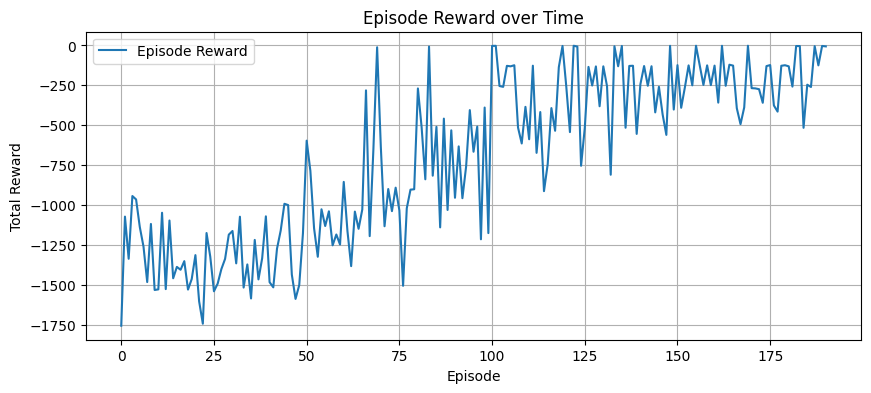

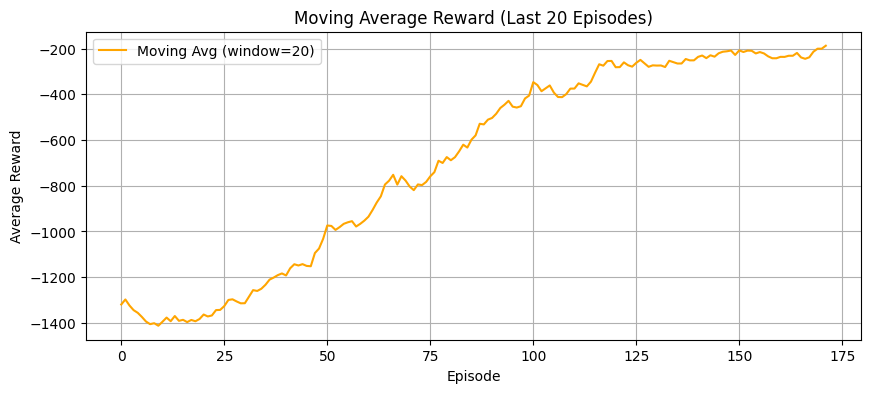

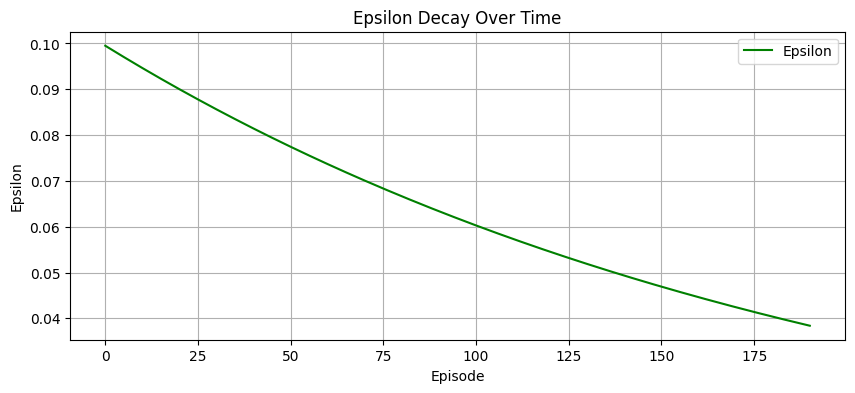

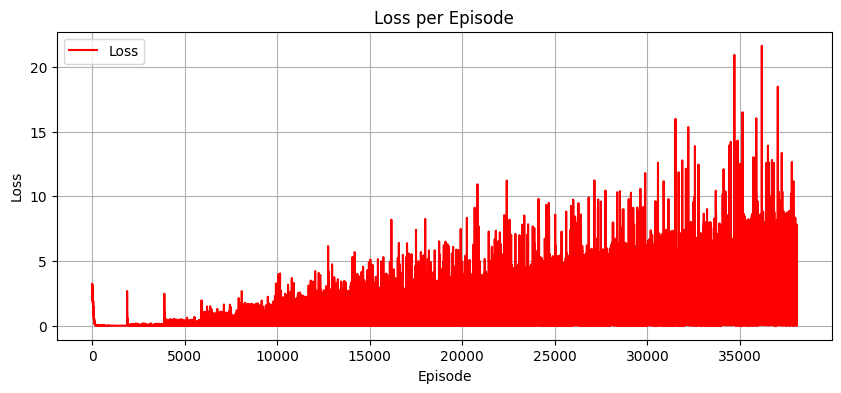

In [8]:
plot_episode_rewards(reward_history)
plot_moving_avg(reward_history, window=20)
plot_epsilon(epsilon_history)
plot_loss(base_agent.loss_history)


# Improved DQN Model

- **Tunable Network Architecture:**  
  Added parameters for number of neurons in each hidden layer (`layer1_num`, `layer2_num`, optional `layer3_num`) and configurable activation function (`ActivationFn`). This allows flexible model design tailored to specific tasks.

- **Configurable Learning Rate:**  
  The optimizer’s learning rate can now be set via `LearningRate`, giving finer control over training dynamics.

- **Explicit Tensor Type Handling:**  
  Inputs and targets are explicitly converted to `tf.float32` tensors in training, improving type consistency and avoiding potential runtime issues.

- **Model Rebuilding with Updated Architecture:**  
  The main and target networks are rebuilt after initialization to reflect new architecture parameters, with weights synchronized between them.

- **Hard Target Network Update:**  
  The target network weights are updated by copying from the main network every fixed number of episodes (`UpdateTargetEveryThisEpisodes`) to stabilize training. (This was already present in the base DQN.)

| Aspect                  | DQN                                  | ImprovedDQN                                       |
|-------------------------|-------------------------------------|--------------------------------------------------|
| Hidden layers           | Fixed 2 layers, same size            | 2 customizable + optional 3rd layer               |
| Hidden layer sizes      | One shared size (`IntermediateSize`) | Separate sizes (`layer1_num`, `layer2_num`, `layer3_num`) |
| Activation functions    | Fixed `'relu'`                      | Configurable (`ActivationFn`)                      |
| Optimizer learning rate | Default Adam                        | Configurable Adam with `LearningRate`              |
| Tensor type handling    | Basic tensor conversion             | Explicit float32 conversion                         |
| Model rebuilding        | Once in constructor                 | Rebuilds with updated architecture parameters      |


In [7]:
class ImprovedDQN(DQN):
  def __init__(self,
               InputShape,
               NActions,
               Gamma,
               ReplayMemorySize,
               MinReplayMemory,
               UpdateTargetEveryThisEpisodes,
               BatchSize,
               layer1_num=64,
               layer2_num=64,
               use_layer3=False,
               layer3_num=64,
               ActivationFn='relu',
               LearningRate=0.001):

    # Architecture parameters
    self.layer1_num = layer1_num
    self.layer2_num = layer2_num
    self.layer3_num = layer3_num
    self.use_layer3 = use_layer3
    self.ActivationFn = ActivationFn
    self.LearningRate = LearningRate

    # Initialize parent with compatibility for IntermediateSize param
    super().__init__(InputShape, NActions, Gamma, ReplayMemorySize,
                     MinReplayMemory, UpdateTargetEveryThisEpisodes,
                     IntermediateSize=layer1_num,  # For backward compatibility
                     BatchSize=BatchSize)

    # Rebuild models using new architecture
    self.Main = self.CreateModel('Main')
    self.Target = self.CreateModel('Target')
    self.Target.set_weights(self.Main.get_weights())  # Sync weights

    # Custom optimizer with specified learning rate
    self.Optimiser = Adam(learning_rate=self.LearningRate)

  def CreateModel(self, Type):
    inputs = Input(shape=(self.InputShape,), name='Input')
    x = Dense(self.layer1_num, activation=self.ActivationFn, name='1stHiddenLayer')(inputs)
    x = Dense(self.layer2_num, activation=self.ActivationFn, name='2ndHiddenLayer')(x)
    if self.use_layer3:
      x = Dense(self.layer3_num, activation=self.ActivationFn, name='3rdHiddenLayer')(x)
    outputs = Dense(self.NActions, activation='linear', name='Output')(x)

    model = Model(inputs, outputs, name=f'{Type}')
    model.summary()
    return model

  @tf.function
  def GTfit(self, X, Y):
    X_tensor = tf.convert_to_tensor(X, dtype=tf.float32)
    Y_tensor = tf.convert_to_tensor(Y, dtype=tf.float32)

    with tf.GradientTape() as tape:
      predictions = self.Main(X_tensor, training=True)
      loss = tf.reduce_mean(tf.square(Y_tensor - predictions))
    grads = tape.gradient(loss, self.Main.trainable_variables)
    self.Optimiser.apply_gradients(zip(grads, self.Main.trainable_variables))
    return loss



## Preprocessing and Training with Improved DQN

- **State Preprocessing:** Normalizes the angular velocity component of the pendulum state for more stable learning.
- **OneEpisode:** Runs a full episode using epsilon-greedy action selection and updates the agent’s replay memory and training.
- **Training Loop:**  
  - Decays epsilon after each episode to reduce exploration gradually.  
  - Tracks episode rewards and losses.  
  - Implements early stopping with model saving once the recent average reward exceeds the threshold.  
  - Prints episode statistics including reward, loss, epsilon, and timing.


In [8]:
def preprocess_state(state):
  # Normalize state input, especially angular velocity (state[2])
  state = np.array(state, dtype=np.float32)
  state[2] = state[2] / 8.0  # Normalize θ̇
  return state

def OneEpisode(agent, env, action_bins, epsilon):
  S = preprocess_state(env.reset())
  Done = False
  total_reward = 0
  max_steps = 200
  steps = 0

  while not Done and steps < max_steps:
    # Get Q-values and choose action with epsilon-greedy
    q_vals = agent.Main(S.reshape(1, -1), training=False).numpy()[0]
    A = np.random.randint(0, agent.NActions) if np.random.rand() < epsilon else np.argmax(q_vals)

    # Take action and get next state/reward
    SNext, R, Done, _ = env.step([action_bins[A]])
    SNext = preprocess_state(SNext)
    total_reward += R

    env.render()

    # Store experience and train (not end of episode yet)
    agent.UpdateReplayMemory((S, A, R, SNext, Done))
    agent.Train(EndOfEpisode=False)

    S = SNext
    steps += 1

  # Final training call at episode end
  agent.Train(EndOfEpisode=True)

  return total_reward

def train_agent(agent, env, action_bins, episodes=500, early_stopping_threshold=-200,
                Epsilon=Epsilon, EpsilonDecay=EpsilonDecay, EpsilonMin=EpsilonMin):

  STARTTIME = time.time()
  reward_history = []
  epsilon_history = []
  best_avg_reward = -np.inf

  for ep in range(episodes):
    ep_start = time.time()
    start_idx = len(agent.loss_history)

    # Run one episode
    total_reward = OneEpisode(agent, env, action_bins, Epsilon)
    reward_history.append(total_reward)

    # Decay epsilon
    Epsilon = max(EpsilonMin, Epsilon * EpsilonDecay)
    epsilon_history.append(Epsilon)

    # Calculate episode loss average
    ep_losses = agent.loss_history[start_idx:]
    ep_loss = sum(ep_losses) / len(ep_losses) if ep_losses else 0.0

    # Reward statistics
    avg_reward = sum(reward_history) / len(reward_history)
    last20_avg_reward = sum(reward_history[-20:]) / len(reward_history[-20:])

    ep_time = time.time() - ep_start
    print(f"Episode {ep+1} |Time: {ep_time:5.2f}s | Reward: {total_reward:.2f} | "
          f"Avg: {avg_reward:.2f} | Last20Avg: {last20_avg_reward:.2f} | "
          f"ε: {Epsilon:.4f} | Loss: {ep_loss:.4f}")

    # Save model and early stop if good enough performance
    if last20_avg_reward > early_stopping_threshold:
      best_avg_reward = last20_avg_reward
      agent.Main.save("best_model.h5")
      print(f"📦 Saved best model at Episode {ep+1} (avg reward: {best_avg_reward:.2f})")
      print(f"✅ Early stopping at episode {ep+1} with last20_avg_reward = {last20_avg_reward:.2f}")
      break

  print(f"\nTotal time taken: {time.time() - STARTTIME:.2f}s")
  return reward_history, epsilon_history


## Initialize Improved DQN Agent

- Configured with three hidden layers of sizes 128, 64, and 32 neurons.
- Uses `tanh` activation for smoother nonlinearities.
- Learning rate lowered to 0.0005 for more stable gradient updates.
- Target network updates every 10 episodes.
- Adjusted epsilon decay rate for slower exploration reduction.


In [18]:
IDQN = ImprovedDQN(
  InputShape=statesize,
  NActions=numaction,
  Gamma=0.99,
  ReplayMemorySize=100000,
  MinReplayMemory=320,
  UpdateTargetEveryThisEpisodes=10,
  BatchSize=64,
  layer1_num=128,
  layer2_num=64,
  use_layer3=True,
  layer3_num=32,
  ActivationFn='tanh',
  LearningRate=0.0005
)

EpsilonDecay = 0.990


Model: "Main"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 3)]               0         
                                                                 
 1stHiddenLayer (Dense)      (None, 128)               512       
                                                                 
 2ndHiddenLayer (Dense)      (None, 64)                8256      
                                                                 
 3rdHiddenLayer (Dense)      (None, 32)                2080      
                                                                 
 Output (Dense)              (None, 21)                693       
                                                                 


Total params: 11,541
Trainable params: 11,541
Non-trainable params: 0
_________________________________________________________________
Model: "Target"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 3)]               0         
                                                                 
 1stHiddenLayer (Dense)      (None, 128)               512       
                                                                 
 2ndHiddenLayer (Dense)      (None, 64)                8256      
                                                                 
 3rdHiddenLayer (Dense)      (None, 32)                2080      
                                                                 
 Output (Dense)              (None, 21)                693       
                                                                 
Total params: 11,541
Trainable params: 11,541
Non-traina

## Training the Improved DQN Agent

- Runs up to 500 episodes with early stopping based on recent average rewards.
- Epsilon parameters control exploration-exploitation balance.
- Monitors training progress and performance for timely stopping and model saving.


In [19]:
reward_history, epsilon_history = train_agent(
  agent=IDQN,
  env=env,
  action_bins=action_bins,
  episodes=500,                   # Train for up to 500 episodes
  early_stopping_threshold=-200,  # Early stop if last 20 avg reward exceeds this
  Epsilon=Epsilon,
  EpsilonDecay=EpsilonDecay,
  EpsilonMin=EpsilonMin
)

DID NOT TRAIN..., replay memory = 1
DID NOT TRAIN..., replay memory = 2
DID NOT TRAIN..., replay memory = 3
DID NOT TRAIN..., replay memory = 4
DID NOT TRAIN..., replay memory = 5
DID NOT TRAIN..., replay memory = 6
DID NOT TRAIN..., replay memory = 7
DID NOT TRAIN..., replay memory = 8
DID NOT TRAIN..., replay memory = 9
DID NOT TRAIN..., replay memory = 10
DID NOT TRAIN..., replay memory = 11
DID NOT TRAIN..., replay memory = 12
DID NOT TRAIN..., replay memory = 13
DID NOT TRAIN..., replay memory = 14
DID NOT TRAIN..., replay memory = 15
DID NOT TRAIN..., replay memory = 16
DID NOT TRAIN..., replay memory = 17
DID NOT TRAIN..., replay memory = 18
DID NOT TRAIN..., replay memory = 19
DID NOT TRAIN..., replay memory = 20
DID NOT TRAIN..., replay memory = 21
DID NOT TRAIN..., replay memory = 22
DID NOT TRAIN..., replay memory = 23
DID NOT TRAIN..., replay memory = 24
DID NOT TRAIN..., replay memory = 25
DID NOT TRAIN..., replay memory = 26
DID NOT TRAIN..., replay memory = 27
DID NOT TR

## Visualization of Training Progress

- **Episode Rewards:** Shows raw reward per episode to observe learning trends.
- **Moving Average Reward:** Smooths reward curve over 20 episodes for clearer trend detection.
- **Epsilon Decay:** Displays reduction of exploration rate over training.
- **Loss History:** Tracks training loss per batch, indicating model learning stability.


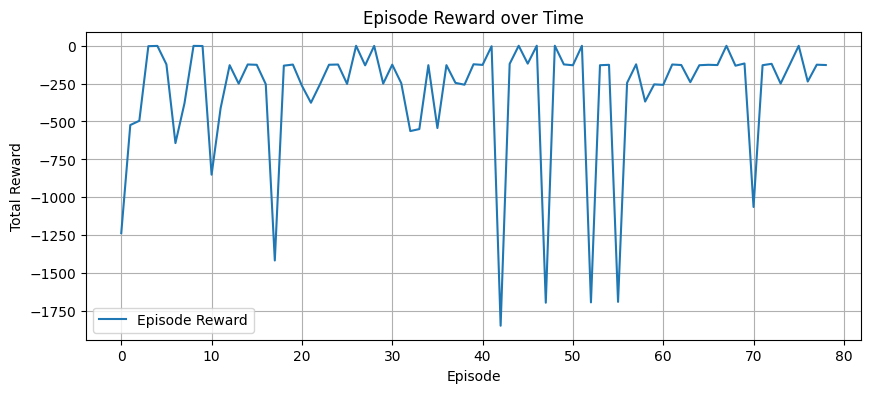

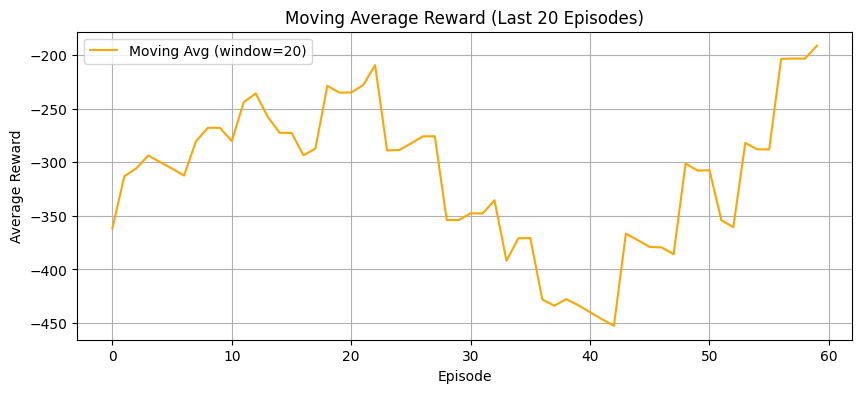

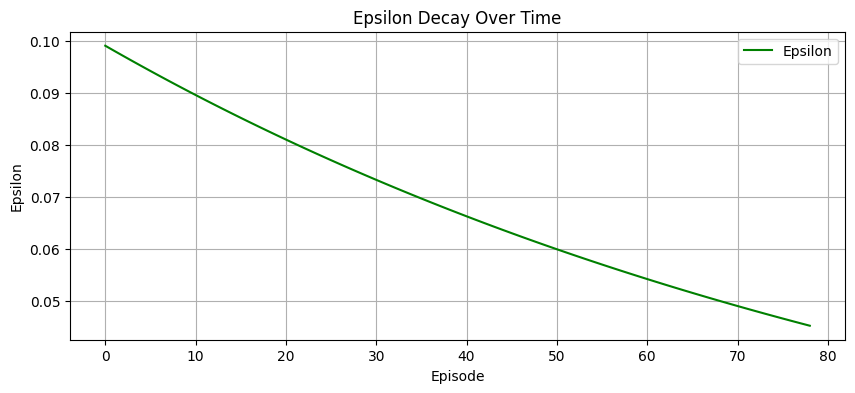

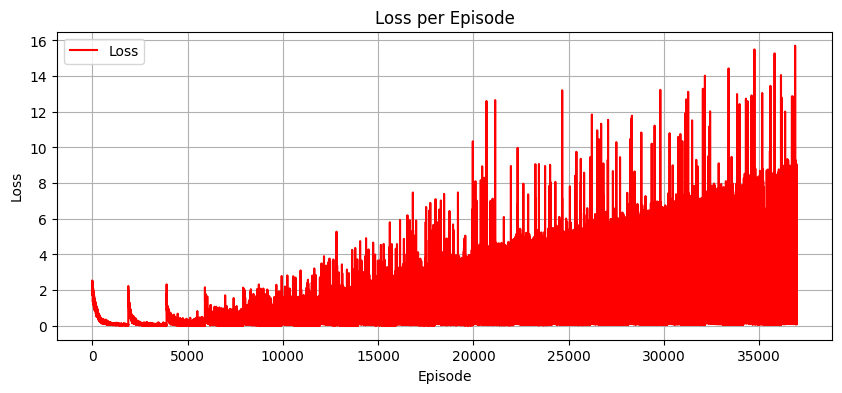

In [14]:
plot_episode_rewards(reward_history)
plot_moving_avg(reward_history, window=20)
plot_epsilon(epsilon_history)
plot_loss(IDQN.loss_history)


# ImprovedDQN Parameter Testing

## Objective
Test various network architectures and hyperparameters to optimize training speed and performance for achieving an average reward of **-150 or better** on the environment.

---

## Tested Models and Configurations

| Model ID | Hidden Layers (sizes)  | Activation | Learning Rate | Batch Size | Epsilon Decay | Replay Memory Size | Early Stop Threshold | Result Summary                            |
|----------|-----------------------|------------|---------------|------------|---------------|--------------------|----------------------|-------------------------------------------|
| 1        | 64, 64, 64                | ReLU       | 0.001         | 64         | 0.99          | 100,000            | -150                 | Early stopped at episode 187 (-147.47 avg reward) |
| 2        | 32, 32, 64                | ReLU       | 0.001         | 64         | 0.99          | 100,000            | -150                 | Did not reach threshold by episode 300  |
| 3        | 64, 128, 64               | ReLU       | 0.001         | 64         | 0.99          | 100,000            | -150                 | Early stopped at episode 235 (-146.16 avg reward) |
| 4        | 128, 32, 64           | ReLU       | 0.001         | 64         | 0.99          | 100,000            | -150                 | Early stopped at episode 163 (-134.24 avg reward) |

In [ ]:
# 1
IDQN = ImprovedDQN(
    InputShape=statesize,
    NActions=numaction,
    Gamma=0.98,
    ReplayMemorySize=100000,
    MinReplayMemory=320,
    UpdateTargetEveryThisEpisodes=10,
    BatchSize=64,
    layer1_num=64,
    layer2_num=64,
    use_layer3=False,
    layer3_num=64,
    ActivationFn='relu',
    LearningRate=0.001
)
EpsilonDecay = 0.995
reward_history, epsilon_history = train_agent(IDQN, env, action_bins, episodes=300, early_stopping_threshold=-150, EpsilonDecay=EpsilonDecay)


Model: "Main"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 3)]               0         
                                                                 
 1stHiddenLayer (Dense)      (None, 64)                256       
                                                                 
 2ndHiddenLayer (Dense)      (None, 64)                4160      
                                                                 
 Output (Dense)              (None, 21)                1365      
                                                                 
Total params: 5,781
Trainable params: 5,781
Non-trainable params: 0
_________________________________________________________________
Model: "Target"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 3)]    

In [ ]:
# 2
IDQN = ImprovedDQN(
    InputShape=statesize,
    NActions=numaction,
    Gamma=0.98,
    ReplayMemorySize=100000,
    MinReplayMemory=320,
    UpdateTargetEveryThisEpisodes=10,
    BatchSize=64,
    layer1_num=32,
    layer2_num=32,
    use_layer3=False,
    layer3_num=64,
    ActivationFn='relu',
    LearningRate=0.001
)
EpsilonDecay = 0.995
reward_history, epsilon_history = train_agent(IDQN, env, action_bins, episodes=300, early_stopping_threshold=-150, EpsilonDecay=EpsilonDecay)


Model: "Main"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 3)]               0         
                                                                 
 1stHiddenLayer (Dense)      (None, 32)                128       
                                                                 
 2ndHiddenLayer (Dense)      (None, 32)                1056      
                                                                 
 Output (Dense)              (None, 21)                693       
                                                                 
Total params: 1,877
Trainable params: 1,877
Non-trainable params: 0
_________________________________________________________________
Model: "Target"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 3)]    

In [ ]:
# 3
IDQN = ImprovedDQN(
    InputShape=statesize,
    NActions=numaction,
    Gamma=0.99,
    ReplayMemorySize=100000,
    MinReplayMemory=320,
    UpdateTargetEveryThisEpisodes=10,
    BatchSize=64,
    layer1_num=64,
    layer2_num=128,
    use_layer3=False,
    layer3_num=64,
    ActivationFn='relu',
    LearningRate=0.0005
)
EpsilonDecay = 0.985
reward_history, epsilon_history = train_agent(IDQN, env, action_bins, episodes=300, early_stopping_threshold=-150, EpsilonDecay=EpsilonDecay)


Model: "Main"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 3)]               0         
                                                                 
 1stHiddenLayer (Dense)      (None, 64)                256       
                                                                 
 2ndHiddenLayer (Dense)      (None, 128)               8320      
                                                                 
 Output (Dense)              (None, 21)                2709      
                                                                 
Total params: 11,285
Trainable params: 11,285
Non-trainable params: 0
_________________________________________________________________
Model: "Target"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 3)]  

In [ ]:
# 4
IDQN = ImprovedDQN(
    InputShape=statesize,
    NActions=numaction,
    Gamma=0.98,
    ReplayMemorySize=100000,
    MinReplayMemory=320,
    UpdateTargetEveryThisEpisodes=10,
    BatchSize=64,
    layer1_num=128,
    layer2_num=32,
    use_layer3=True,
    layer3_num=64,
    ActivationFn='tanh',
    LearningRate=0.0005
)
EpsilonDecay = 0.990
reward_history, epsilon_history = train_agent(IDQN, env, action_bins, episodes=300, early_stopping_threshold=-150, EpsilonDecay=EpsilonDecay)


Model: "Main"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 3)]               0         
                                                                 
 1stHiddenLayer (Dense)      (None, 128)               512       
                                                                 
 2ndHiddenLayer (Dense)      (None, 32)                4128      
                                                                 
 3rdHiddenLayer (Dense)      (None, 64)                2112      
                                                                 
 Output (Dense)              (None, 21)                1365      
                                                                 
Total params: 8,117
Trainable params: 8,117
Non-trainable params: 0
_________________________________________________________________
Model: "Target"
____________________________________________

# Best-Performing ImprovedDQN Adaptation for -120 Avg Reward Target

## Objective
Build on the previously best-performing model from testing to target an average reward of **-120**.

---

## Best Performing Model From Previous Runs
From the earlier experiments, the configuration with:
- **Layer 1:** 128 neurons  
- **Layer 2:** 32 neurons  
- **Layer 3:** 64 neurons  
- **Activation:** Tanh  
- **Learning Rate:** 0.0005  
- **Gamma:** 0.98  
- **Target Update Every:** 10 episodes  
showed the fastest improvement past the -150 threshold.


In [9]:
# Initialize Improved DQN agent
IDQN = ImprovedDQN(
    InputShape=statesize,                  # State vector shape
    NActions=numaction,                    # Number of discrete actions
    Gamma=0.98,                            # Discount factor for future rewards
    ReplayMemorySize=100_000,              # Experience replay buffer size
    MinReplayMemory=320,                   # Minimum samples before training starts
    UpdateTargetEveryThisEpisodes=10,      # Update target network every 10 episodes
    BatchSize=64,                          # Mini-batch size for training
    layer1_num=128,                        # First hidden layer neurons
    layer2_num=32,                         # Second hidden layer neurons
    use_layer3=True,                       # Include third hidden layer
    layer3_num=64,                         # Third hidden layer neurons
    ActivationFn='tanh',                   # Hidden layer activation function
    LearningRate=0.0005                    # Learning rate for optimizer
)

# Epsilon decay rate (controls exploration → exploitation)
EpsilonDecay = 0.990

# Train agent
reward_history, epsilon_history = train_agent(
    agent=IDQN,
    env=env,
    action_bins=action_bins,
    episodes=500,                          # Longer training
    early_stopping_threshold=-120,         # Stop when average reward exceeds this
    EpsilonDecay=EpsilonDecay
)


Model: "Main"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 3)]               0         
                                                                 
 1stHiddenLayer (Dense)      (None, 128)               512       
                                                                 
 2ndHiddenLayer (Dense)      (None, 32)                4128      
                                                                 
 3rdHiddenLayer (Dense)      (None, 64)                2112      
                                                                 
 Output (Dense)              (None, 21)                1365      
                                                                 
Total params: 8,117
Trainable params: 8,117
Non-trainable params: 0
_________________________________________________________________
Model: "Target"
____________________________________________

## Visualization of Training Progress

- **Episode Rewards:** Shows raw reward per episode to observe learning trends.
- **Moving Average Reward:** Smooths reward curve over 20 episodes for clearer trend detection.
- **Epsilon Decay:** Displays reduction of exploration rate over training.
- **Loss History:** Tracks training loss per batch, indicating model learning stability.


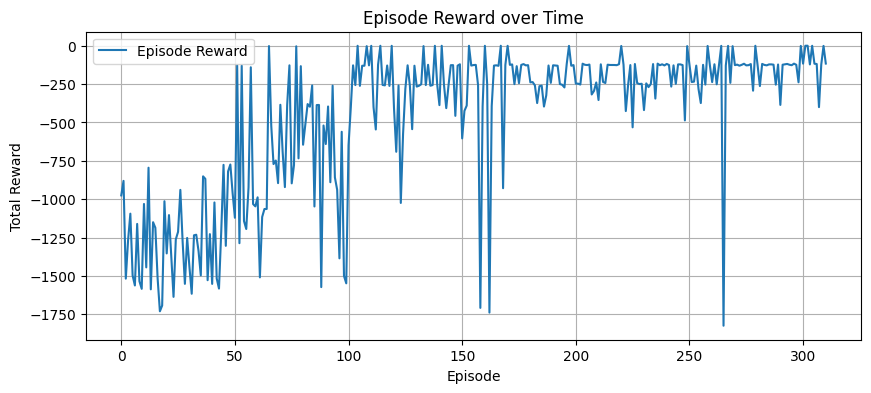

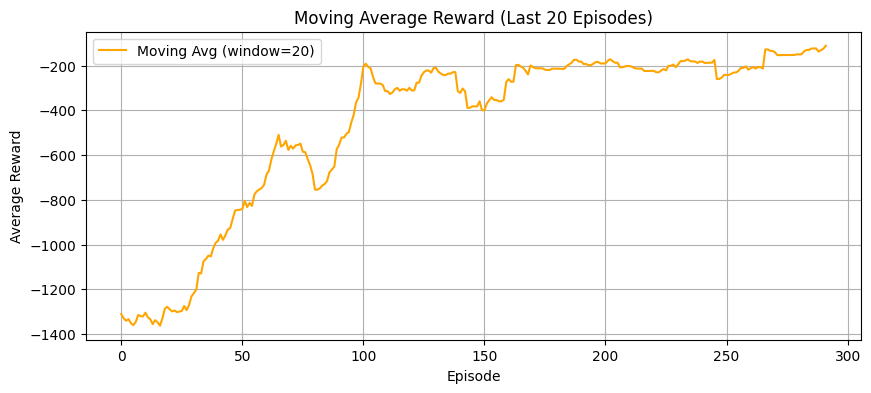

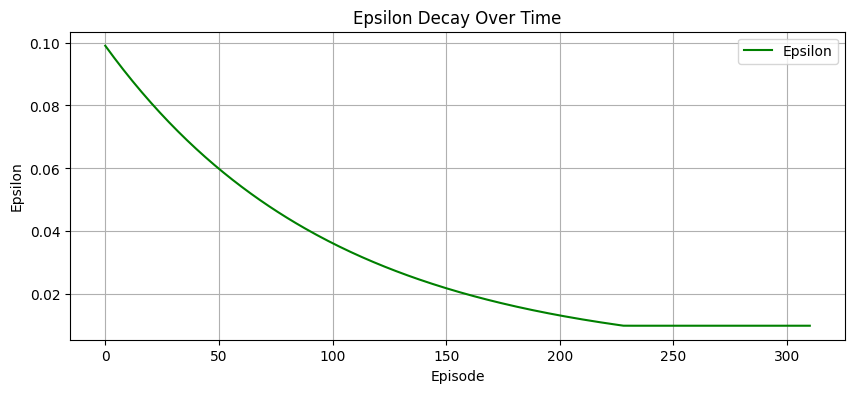

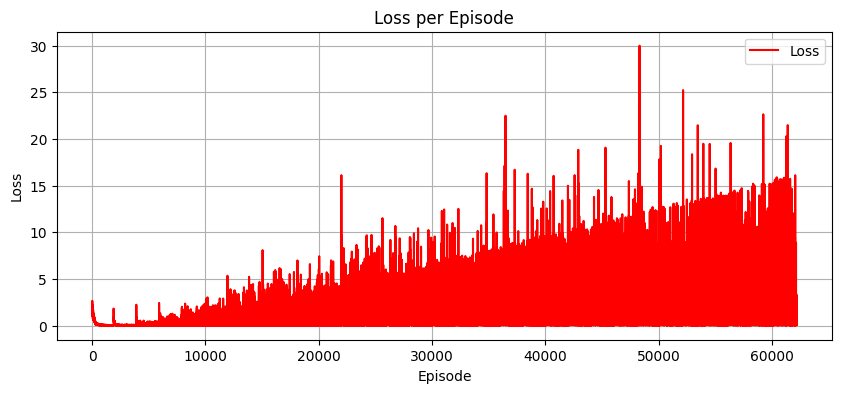

In [11]:
plot_episode_rewards(reward_history)
plot_moving_avg(reward_history, window=20)
plot_epsilon(epsilon_history)
plot_loss(IDQN.loss_history)


## Rendering Trained Agent Performance to Video

- Loads the best model and the Pendulum environment.
- Runs 5 episodes without exploration to demonstrate learned policy.
- Records each frame, annotates it with step and reward info.
- Saves output as an MP4 video.
- Includes error handling to ensure clear feedback if model file is missing or loading fails.


In [ ]:
from tensorflow.keras.models import load_model
import imageio

def render_pendulum_to_mp4(
  model_path='best_model.h5',
  env_string='Pendulum-v0',
  filename='dqn_pendulum_trained.mp4',
  num_episodes=5
):
  """
  Load a trained Pendulum model and render its performance, saving as MP4.

  Args:
    model_path: Path to the saved H5 model file
    env_string: Environment name (e.g., 'Pendulum-v0')
    filename: Name of the output .mp4 video file
    num_episodes: Number of episodes to record
  """

  # Load trained model
  try:
    model = load_model(model_path)
    print(f"✅ Model loaded successfully from: {model_path}")
  except Exception as e:
    print(f"❌ Error loading model from {model_path}: {e}")
    return

  # Create environment and setup action bins
  env = gym.make(env_string)
  action_bins = 21
  action_space = np.linspace(-2.0, 2.0, action_bins)

  def preprocess_state(state):
    # Normalize angular velocity similar to training
    state = np.array(state, dtype=np.float32)
    state[2] = state[2] / 8.0
    return np.reshape(state, [1, 3])  # shape (1, 3)

  def get_continuous_action(discrete_action_index):
    return np.array([action_space[discrete_action_index]])

  # Initialize video writer
  writer = imageio.get_writer(f'{filename}', fps=30)

  for episode in range(num_episodes):
    state = env.reset()
    state = preprocess_state(state)
    done = False
    total_reward = 0
    step = 0
    max_steps = 200

    print(f"\n🎥 Recording Episode {episode+1}/{num_episodes}")

    while not done and step < max_steps:
      # Render environment frame as RGB array
      frame = env.render(mode='rgb_array')

      # Annotate frame with matplotlib
      fig, ax = plt.subplots(figsize=(6, 4))
      ax.imshow(frame)
      ax.set_title(f"Episode {episode+1} - Step {step} - Reward: {total_reward:.1f}")
      ax.axis('off')
      fig.canvas.draw()

      # Convert plot to image array and write to video
      plot_frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
      plot_frame = plot_frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
      writer.append_data(plot_frame)
      plt.close(fig)

      # Select action (no epsilon, pure exploitation)
      q_values = model(state)
      discrete_action = np.argmax(q_values)
      continuous_action = get_continuous_action(discrete_action)

      # Step environment
      next_state, reward, done, _ = env.step(continuous_action)
      next_state = preprocess_state(next_state)

      total_reward += reward
      state = next_state
      step += 1

    print(f"✅ Episode {episode+1} total reward: {total_reward:.2f}")

  writer.close()
  env.close()
  print(f"\n📼 Video saved as: {filename}")


# Safely call the function with error handling
try:
  render_pendulum_to_mp4(
    model_path='best_model.h5',
    env_string='Pendulum-v0',
    filename='dqn_pendulum_trained.mp4',
    num_episodes=5
  )
except Exception as e:
  print(f"⚠️ Could not create video: {e}")
  print("Make sure the model is trained and 'best_model.h5' exists.")


✅ Model loaded successfully from: best_model.h5

🎥 Recording Episode 1/5


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


✅ Episode 1 total reward: -127.82

🎥 Recording Episode 2/5
✅ Episode 2 total reward: -1.12

🎥 Recording Episode 3/5
✅ Episode 3 total reward: -122.70

🎥 Recording Episode 4/5
✅ Episode 4 total reward: -118.33

🎥 Recording Episode 5/5
✅ Episode 5 total reward: -125.39

📼 Video saved as: videos/dqn_pendulum_trained.mp4
